In [1]:
#load needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


#### loading data

In [2]:
#reading data
filePath = "hlth_silc_10_Incom.tsv"
df = pd.DataFrame(pd.read_csv(filePath, sep="\t"))
df

,"freq,unit,isced11,age,sex,levels,geo\TIMEPERIOD",2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,"A,PC,QU1,YGE16,F,BAD,AL",:,:,:,:,:,:,:,:,:,:,:,:,5.9,5.2,4.2,3.3,:
1,"A,PC,QU1,YGE16,F,BAD,AT",11.4,12.1,12.0,12.0,10.7,12.6,13.5,9.6,11.3,13.0,11.5,9.3,10.6,10.2,11.1,11.0,10.1
2,"A,PC,QU1,YGE16,F,BAD,BE",11.7,15.0,14.4,15.0,14.7,14.7,16.0,13.9,15.2,17.2,19.4,14.5,15.7,15.1,14.3 b,15.8,15.2
3,"A,PC,QU1,YGE16,F,BAD,BG",24.3,24.3,20.2,21.6,21.5,20.3,19.4,19.1,18.6,14.7,19.5,15.3,18.0,16.9,16.0,16.5,16.0
4,"A,PC,QU1,YGE16,F,BAD,CH",:,:,7.5,5.4,5.6,6.1,5.2,4.9,6.0,6.4,6.9,6.3,6.8,7.3,5.9,5.1,:
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,"A,PC,TOTAL,YGE16,T,VGG,SI",53.6,56.4,57.9,58.8,60.0,59.7,60.5,63.1,64.8,64.8,64.8,64.5,65.3,65.4,66.7,67.2,69.1
5540,"A,PC,TOTAL,YGE16,T,VGG,SK",52.2,52.2,53.1,59.7,62.1,63.7,63.4,65.8,66.1,64.7,66.0,66.5,67.1,66.7,65.2,65.3,:
5541,"A,PC,TOTAL,YGE16,T,VGG,TR",:,62.7,66.1,67.3,64.4,65.3,66.6,68.0,67.2,67.5,65.7,68.8,68.2,67.1,66.4,68.8,:
5542,"A,PC,TOTAL,YGE16,T,VGG,UK",74.9,76.6,77.4,80.1,79.9,79.7,77.5,74.8,73.7,69.9,69.8,69.0,74.8 b,73.2,:,:,:


#### prepare data for analyzing

In [3]:
colCountOld = len(df.columns)
#splitting index to main columns 
headerAttributes = df.columns[0].split(",") #make new string for header of new columns by splitting the old column header name
df[headerAttributes] = df.iloc[:, 0].str.split(",", expand = True) #split the value of given column and put them in new columns which are made in previous line
df = df.drop(df.columns[[0]], axis=1) #eliminate old column 
colCountNew = len(df.columns)
print (colCountOld, colCountNew)

18 24


In [4]:
#convert data type
#remove characters from the year cells
fromColInx = 0
ToColIndx = colCountOld - 1
df.iloc[:, fromColInx:ToColIndx] = df.iloc[:, fromColInx:ToColIndx].replace("[^\d+\.]+" , '' , regex=True) #replace all spaces and non-digit characters by nothing execpt . for float ones
df.iloc[:, fromColInx:ToColIndx] = df.iloc[:, fromColInx:ToColIndx].replace('' , 0 , regex=False) ##replace empty values by 0 value
df.iloc[:, fromColInx:ToColIndx] = df.iloc[:, fromColInx:ToColIndx].astype(float)
df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2019,2020,2021,freq,unit,isced11,age,sex,levels,geo\TIMEPERIOD
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.2,3.3,0.0,A,PC,QU1,YGE16,F,BAD,AL
1,11.4,12.1,12.0,12.0,10.7,12.6,13.5,9.6,11.3,13.0,...,11.1,11.0,10.1,A,PC,QU1,YGE16,F,BAD,AT
2,11.7,15.0,14.4,15.0,14.7,14.7,16.0,13.9,15.2,17.2,...,14.3,15.8,15.2,A,PC,QU1,YGE16,F,BAD,BE
3,24.3,24.3,20.2,21.6,21.5,20.3,19.4,19.1,18.6,14.7,...,16.0,16.5,16.0,A,PC,QU1,YGE16,F,BAD,BG
4,0.0,0.0,7.5,5.4,5.6,6.1,5.2,4.9,6.0,6.4,...,5.9,5.1,0.0,A,PC,QU1,YGE16,F,BAD,CH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,53.6,56.4,57.9,58.8,60.0,59.7,60.5,63.1,64.8,64.8,...,66.7,67.2,69.1,A,PC,TOTAL,YGE16,T,VGG,SI
5540,52.2,52.2,53.1,59.7,62.1,63.7,63.4,65.8,66.1,64.7,...,65.2,65.3,0.0,A,PC,TOTAL,YGE16,T,VGG,SK
5541,0.0,62.7,66.1,67.3,64.4,65.3,66.6,68.0,67.2,67.5,...,66.4,68.8,0.0,A,PC,TOTAL,YGE16,T,VGG,TR
5542,74.9,76.6,77.4,80.1,79.9,79.7,77.5,74.8,73.7,69.9,...,0.0,0.0,0.0,A,PC,TOTAL,YGE16,T,VGG,UK


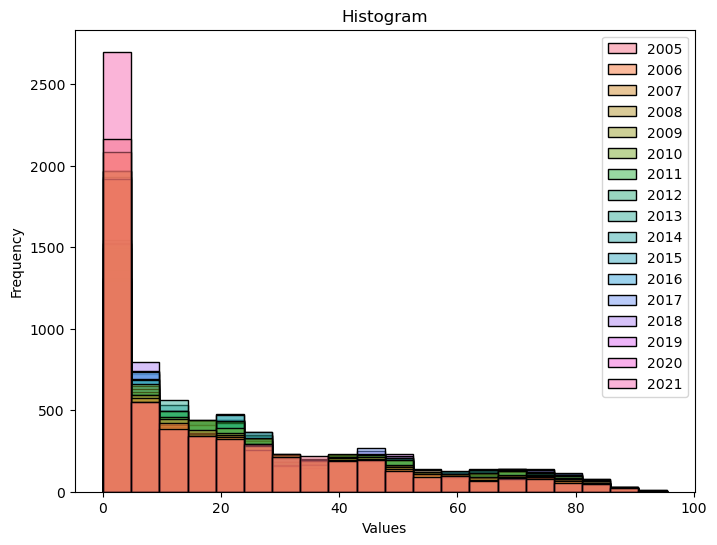

In [5]:
#check the normalization of data
# Extract the relevant columns for plotting
years = range(2005, 2022)  # Assuming your dataset contains data from 2005 to 2021
data = df.loc[:, '2005':'2021']

# Create histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(data, kde=False, bins=20)  # Adjust the number of bins as needed
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram')
plt.show()

In [6]:
#As the data has such a Gamma destribution, we use mean for calculation of years
df["meanYear"] = df[df.columns[fromColInx:ToColIndx]].mean(axis = 1)
df

,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,...,2020,2021,freq,unit,isced11,age,sex,levels,geo\TIMEPERIOD,meanYear
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.3,0.0,A,PC,QU1,YGE16,F,BAD,AL,1.094118
1,11.4,12.1,12.0,12.0,10.7,12.6,13.5,9.6,11.3,13.0,...,11.0,10.1,A,PC,QU1,YGE16,F,BAD,AT,11.294118
2,11.7,15.0,14.4,15.0,14.7,14.7,16.0,13.9,15.2,17.2,...,15.8,15.2,A,PC,QU1,YGE16,F,BAD,BE,15.164706
3,24.3,24.3,20.2,21.6,21.5,20.3,19.4,19.1,18.6,14.7,...,16.5,16.0,A,PC,QU1,YGE16,F,BAD,BG,18.952941
4,0.0,0.0,7.5,5.4,5.6,6.1,5.2,4.9,6.0,6.4,...,5.1,0.0,A,PC,QU1,YGE16,F,BAD,CH,5.023529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5539,53.6,56.4,57.9,58.8,60.0,59.7,60.5,63.1,64.8,64.8,...,67.2,69.1,A,PC,TOTAL,YGE16,T,VGG,SI,62.505882
5540,52.2,52.2,53.1,59.7,62.1,63.7,63.4,65.8,66.1,64.7,...,65.3,0.0,A,PC,TOTAL,YGE16,T,VGG,SK,58.811765
5541,0.0,62.7,66.1,67.3,64.4,65.3,66.6,68.0,67.2,67.5,...,68.8,0.0,A,PC,TOTAL,YGE16,T,VGG,TR,58.829412
5542,74.9,76.6,77.4,80.1,79.9,79.7,77.5,74.8,73.7,69.9,...,0.0,0.0,A,PC,TOTAL,YGE16,T,VGG,UK,61.841176


In [7]:
#making the main data set that need for our analysing
dfMain = df.iloc[:, 17:]
print(dfMain)
#filename = 'dataPrepared.csv'

#with open(filename, 'w', newline='') as tsvfile:
#    writer = csv.writer(tsvfile, delimiter='\t')
#    writer.writerows(dfMain)

     freq unit isced11    age sex levels geo\TIMEPERIOD   meanYear
0       A   PC     QU1  YGE16   F    BAD             AL   1.094118
1       A   PC     QU1  YGE16   F    BAD             AT  11.294118
2       A   PC     QU1  YGE16   F    BAD             BE  15.164706
3       A   PC     QU1  YGE16   F    BAD             BG  18.952941
4       A   PC     QU1  YGE16   F    BAD             CH   5.023529
...   ...  ...     ...    ...  ..    ...            ...        ...
5539    A   PC   TOTAL  YGE16   T    VGG             SI  62.505882
5540    A   PC   TOTAL  YGE16   T    VGG             SK  58.811765
5541    A   PC   TOTAL  YGE16   T    VGG             TR  58.829412
5542    A   PC   TOTAL  YGE16   T    VGG             UK  61.841176
5543    A   PC   TOTAL  YGE16   T    VGG             XK   4.823529

[5544 rows x 8 columns]


In [9]:
#prepare categorical columns for k-mean, because k-mean works by float

from sklearn.preprocessing import LabelEncoder

# Encode categorical features
categorical_features = ["freq", "unit", "isced11", "age", "sex", "levels", "geo\\TIMEPERIOD"]
encoder = LabelEncoder()

for feature in categorical_features:
    df[feature] = encoder.fit_transform(df[feature])

# Select the relevant columns for clustering
selected_features = ["freq", "unit", "isced11", "age", "sex", "levels", "geo\\TIMEPERIOD", "meanYear"]
X = df[selected_features]

#### Kmean & SpectralClustering Clustering

In [10]:
# Perform clustering with k-means
from sklearn.cluster import KMeans

K=7
kmeans = KMeans(n_clusters=K)  
kmeans.fit(X)
kmeans_labels = kmeans.labels_

# Perform clustering with spectral clustering
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=K)  
spectral_labels = spectral.fit_predict(X)


#### Visualizing result

As some columns such as sex or level have limit value so clustering of them are like a line. I plot one sample of those type of data. and main focus is on the geo and meanYear

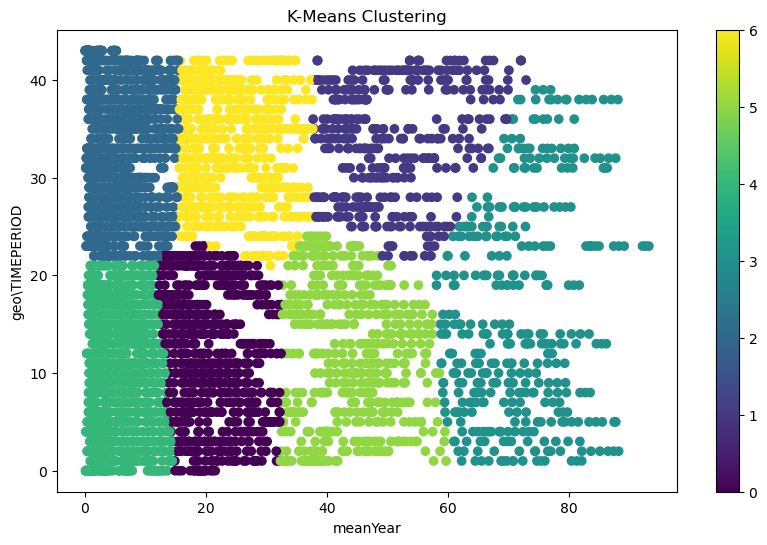

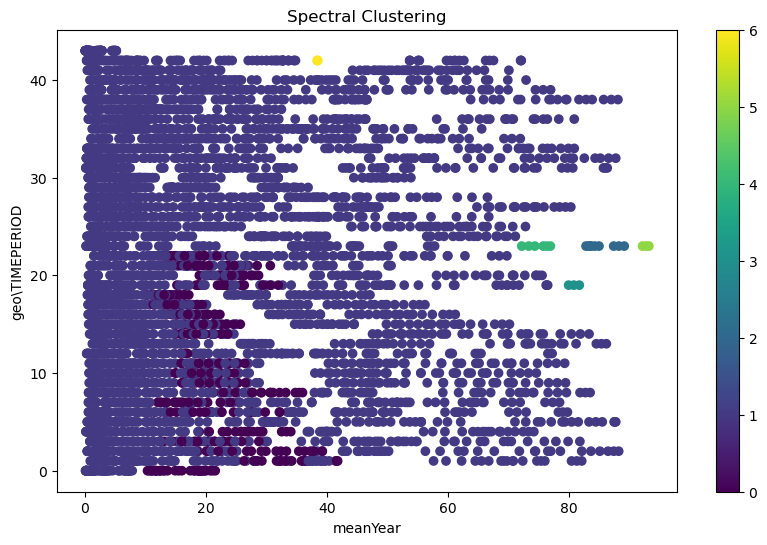

In [11]:
# meanYear & geo\\TIMEPERIOD

import matplotlib.pyplot as plt

# Plot the data with k-means results
plt.figure(figsize=(10, 6))
plt.scatter(X["meanYear"], X["geo\\TIMEPERIOD"], c=kmeans_labels, cmap="viridis")
plt.xlabel("meanYear")
plt.ylabel("geo\\TIMEPERIOD")
plt.title("K-Means Clustering")
plt.colorbar()
plt.show()

# Plot the data with spectral clustering results
plt.figure(figsize=(10, 6))
plt.scatter(X["meanYear"], X["geo\\TIMEPERIOD"], c=spectral_labels, cmap="viridis")
plt.xlabel("meanYear")
plt.ylabel("geo\\TIMEPERIOD")
plt.title("Spectral Clustering")
plt.colorbar()
plt.show()


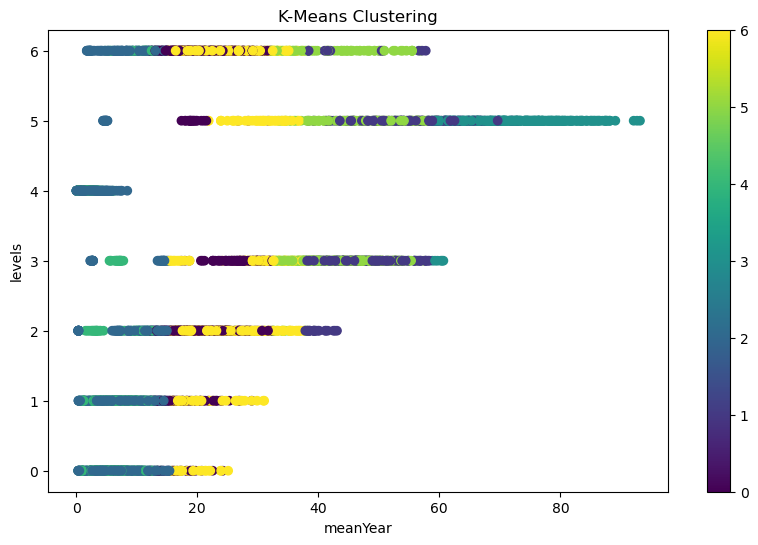

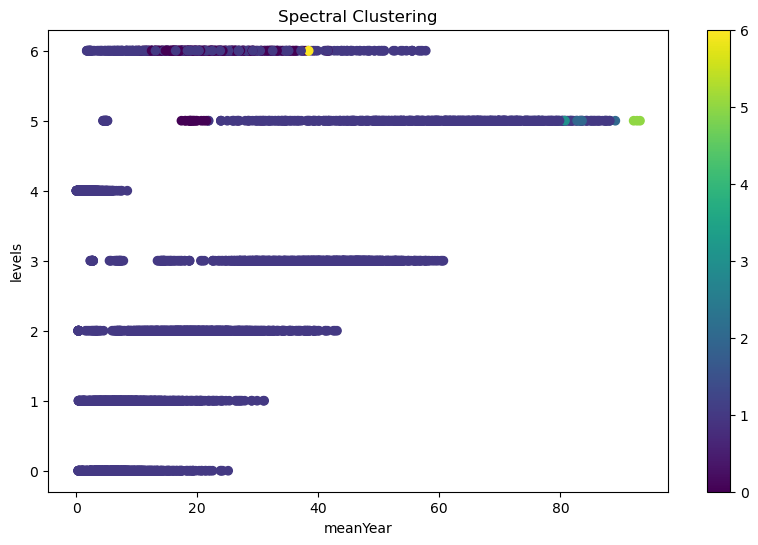

In [12]:
#level & meanYear

import matplotlib.pyplot as plt

# Plot the data with k-means results
plt.figure(figsize=(10, 6))
plt.scatter(X["meanYear"], X["levels"], c=kmeans_labels, cmap="viridis")
plt.xlabel("meanYear")
plt.ylabel("levels")
plt.title("K-Means Clustering")
plt.colorbar()
plt.show()

# Plot the data with spectral clustering results
plt.figure(figsize=(10, 6))
plt.scatter(X["meanYear"], X["levels"], c=spectral_labels, cmap="viridis")
plt.xlabel("meanYear")
plt.ylabel("levels")
plt.title("Spectral Clustering")
plt.colorbar()
plt.show()

#### PCA and t-sne

In [13]:
#PCA calculation
from sklearn.decomposition import PCA

pca = PCA(n_components=2) 
pca_result = pca.fit_transform(X)


#t-sne calculation
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2) 
tsne_result = tsne.fit_transform(X)

c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Lenovo\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


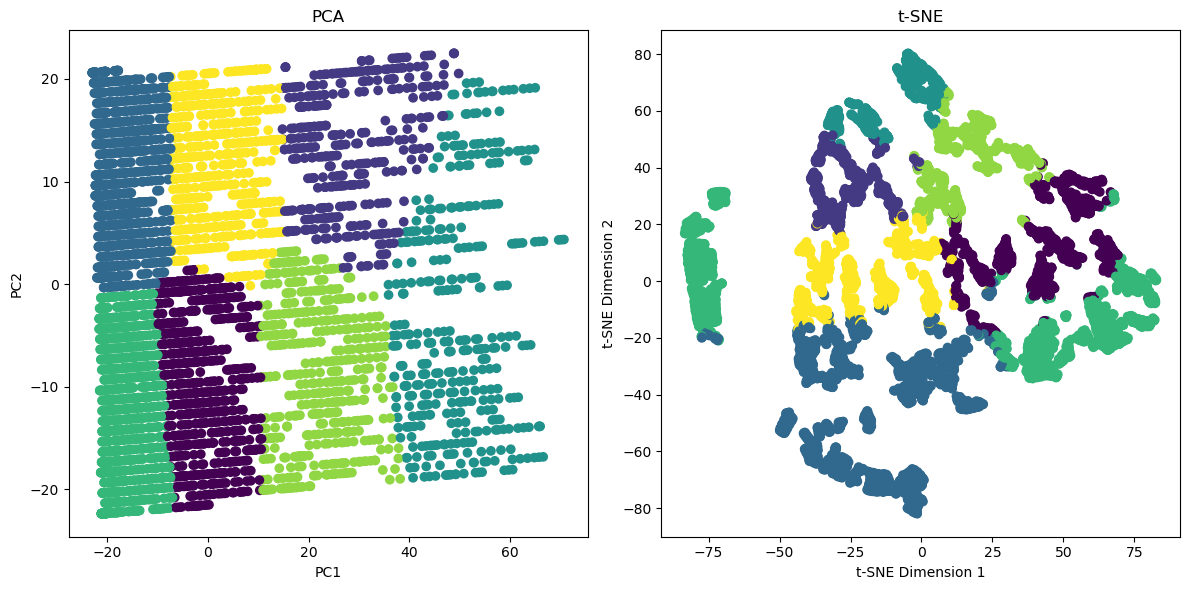

In [14]:
#visualize PCA and t-sne result

plt.figure(figsize=(12, 6))

# Plot PCA results
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=kmeans_labels, cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA")

# Plot t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=kmeans_labels, cmap="viridis")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE")

plt.tight_layout()
plt.show()